In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

Preprocessing

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Atukuri Praneetha
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


100%|██████████| 34.1M/34.1M [00:00<00:00, 77.9MB/s]


In [ ]:
!pip install tensorflow matplotlib seaborn scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Set paths for training data
train_dir = '/content/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'

In [ ]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
original_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Create generators
original_generator = original_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=1,  # Load one image at a time
    class_mode='binary',
    shuffle=True
)

Found 5121 images belonging to 4 classes.


In [ ]:
augmented_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=1,  # Load one image at a time
    class_mode='binary',
    shuffle=True
)


Found 5121 images belonging to 4 classes.


In [ ]:
# Function to display a batch of images (before and after augmentation)
def display_images(generator, title, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        img, label = next(generator) # Use next(generator) instead of generator.next()
        plt.subplot(1, num_images, i+1)
        plt.imshow(img[0])
        plt.title(f"{title}\nLabel: {int(label[0])}")
        plt.axis('off')
    plt.show()

Original Images (Before Preprocessing):


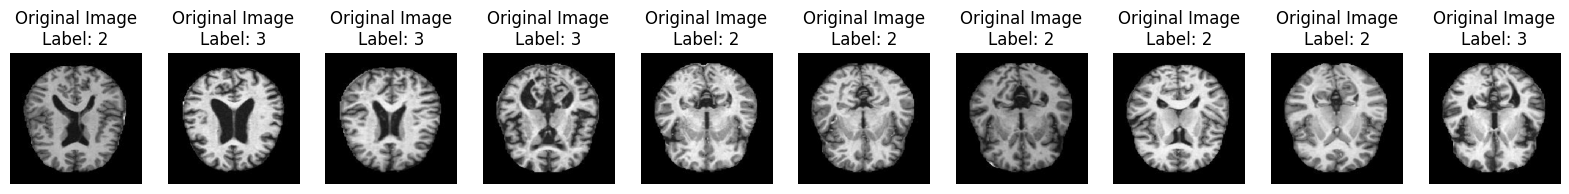

In [ ]:
# Display original images before preprocessing (no augmentation, just rescaling)
print("Original Images (Before Preprocessing):")
display_images(original_generator, title="Original Image", num_images=10)

Augmented Images (After Preprocessing):


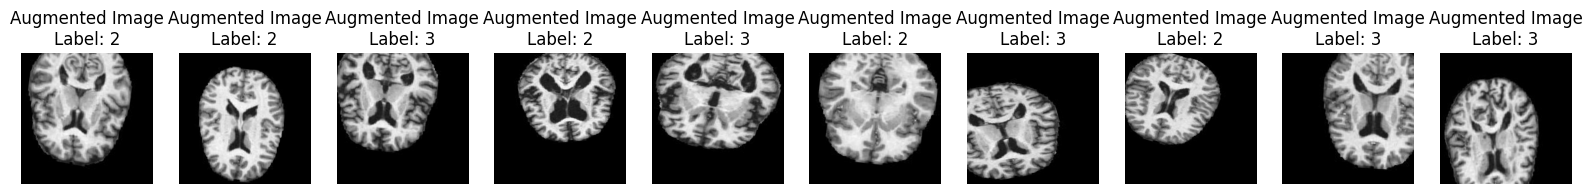

In [ ]:
# Display augmented images after preprocessing
print("Augmented Images (After Preprocessing):")
display_images(augmented_generator, title="Augmented Image", num_images=10)

In [ ]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/content/drive/MyDrive/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/content/drive/MyDrive/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:13<00:00,  6.83s/it]


image             label
0     /content/drive/MyDrive/Alzheimer_s Dataset/tra...      MildDemented
1     /content/drive/MyDrive/Alzheimer_s Dataset/tra...      MildDemented
2     /content/drive/MyDrive/Alzheimer_s Dataset/tra...      MildDemented
3     /content/drive/MyDrive/Alzheimer_s Dataset/tra...      MildDemented
4     /content/drive/MyDrive/Alzheimer_s Dataset/tra...      MildDemented
...                                                 ...               ...
6395  /content/drive/MyDrive/Alzheimer_s Dataset/tes...  ModerateDemented
6396  /content/drive/MyDrive/Alzheimer_s Dataset/tes...  ModerateDemented
6397  /content/drive/MyDrive/Alzheimer_s Dataset/tes...  ModerateDemented
6398  /content/drive/MyDrive/Alzheimer_s Dataset/tes...  ModerateDemented
6399  /content/drive/MyDrive/Alzheimer_s Dataset/tes...  ModerateDemented

[6400 rows x 2 columns]

<ipython-input-4-be9dd1228c04>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set1')


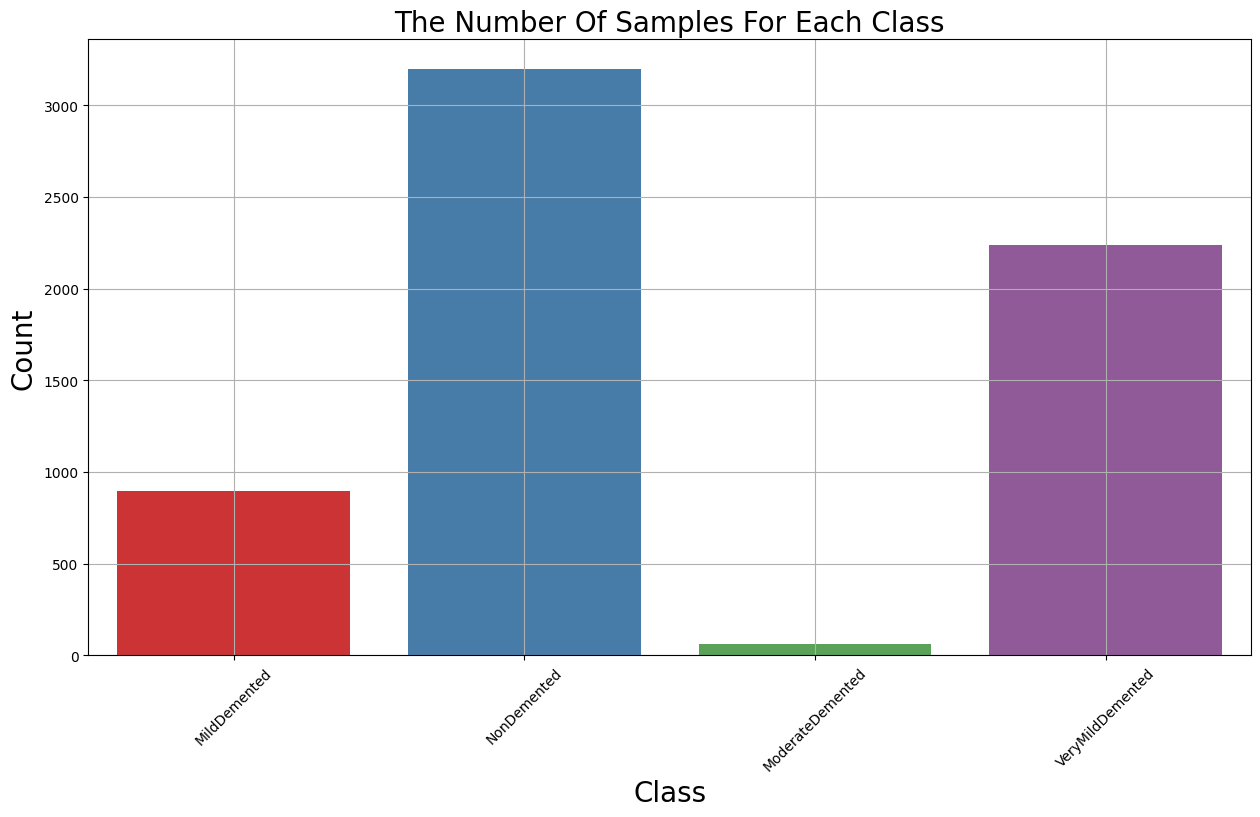

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


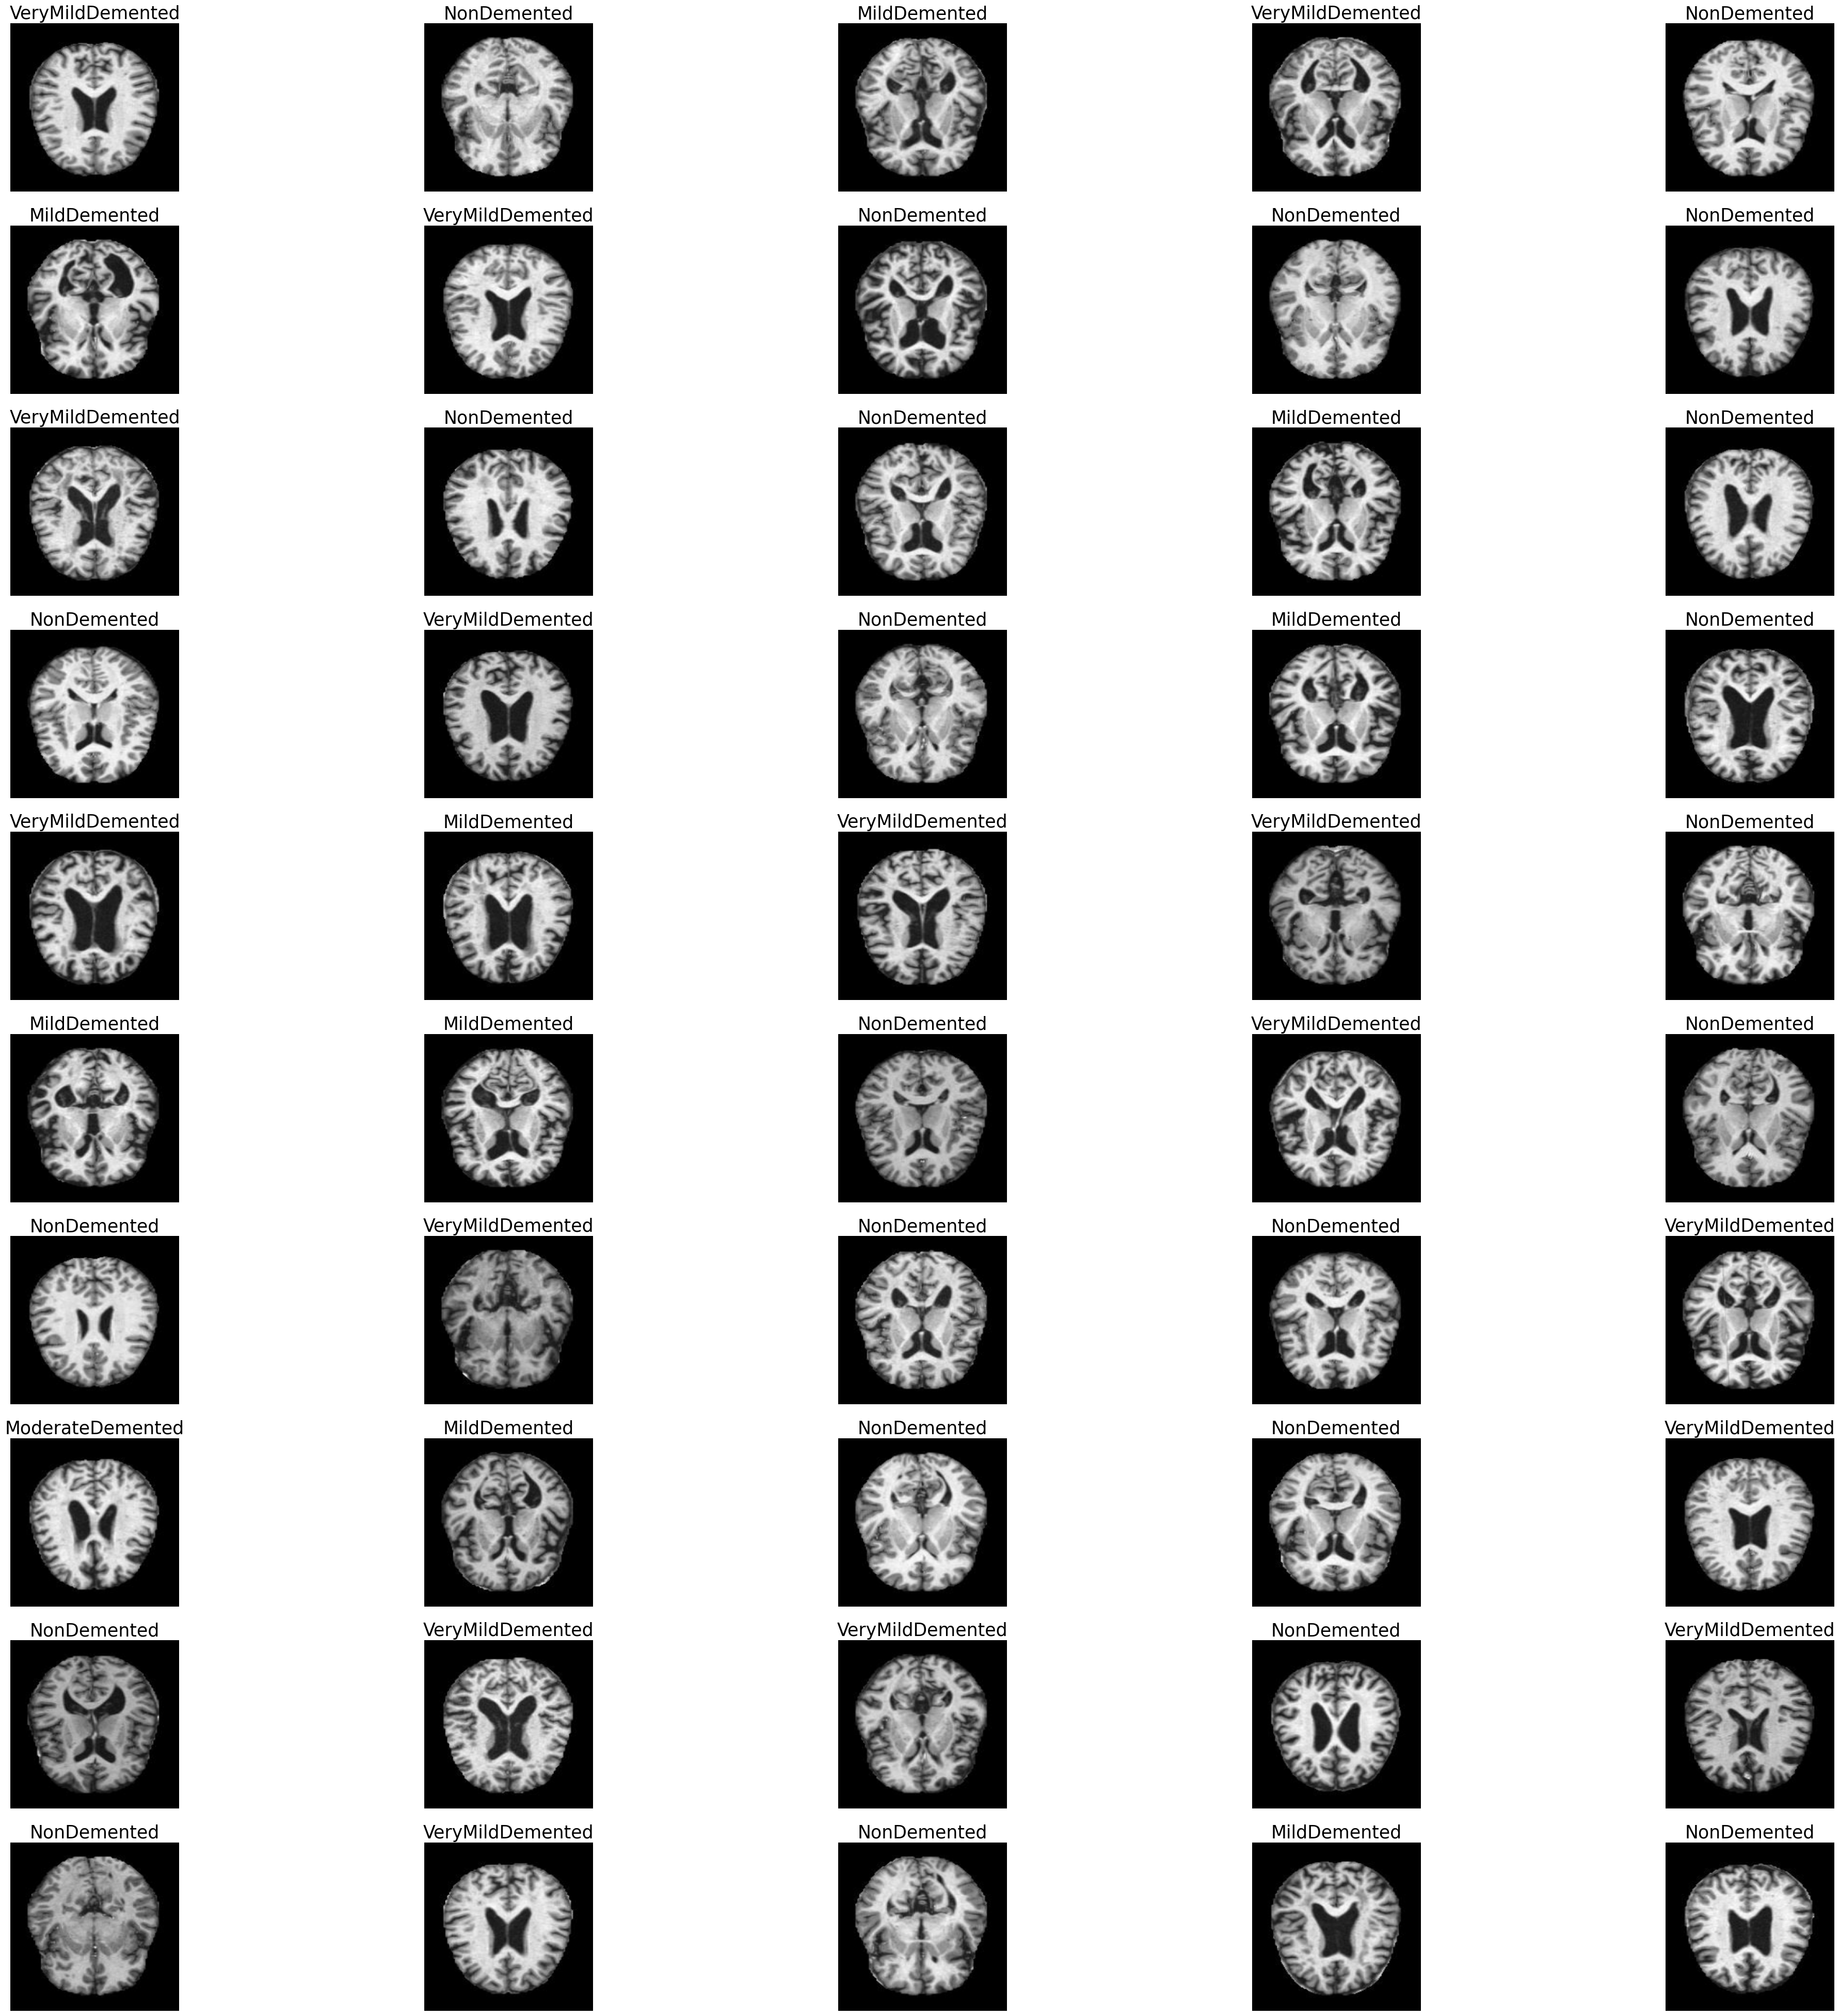

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

CNN MODEL FOR ALZHEIMER'S CLASSIFICATION


In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 88, 88, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 44, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,278,020 (4.88 MB)

 Trainable params: 1,278,020 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

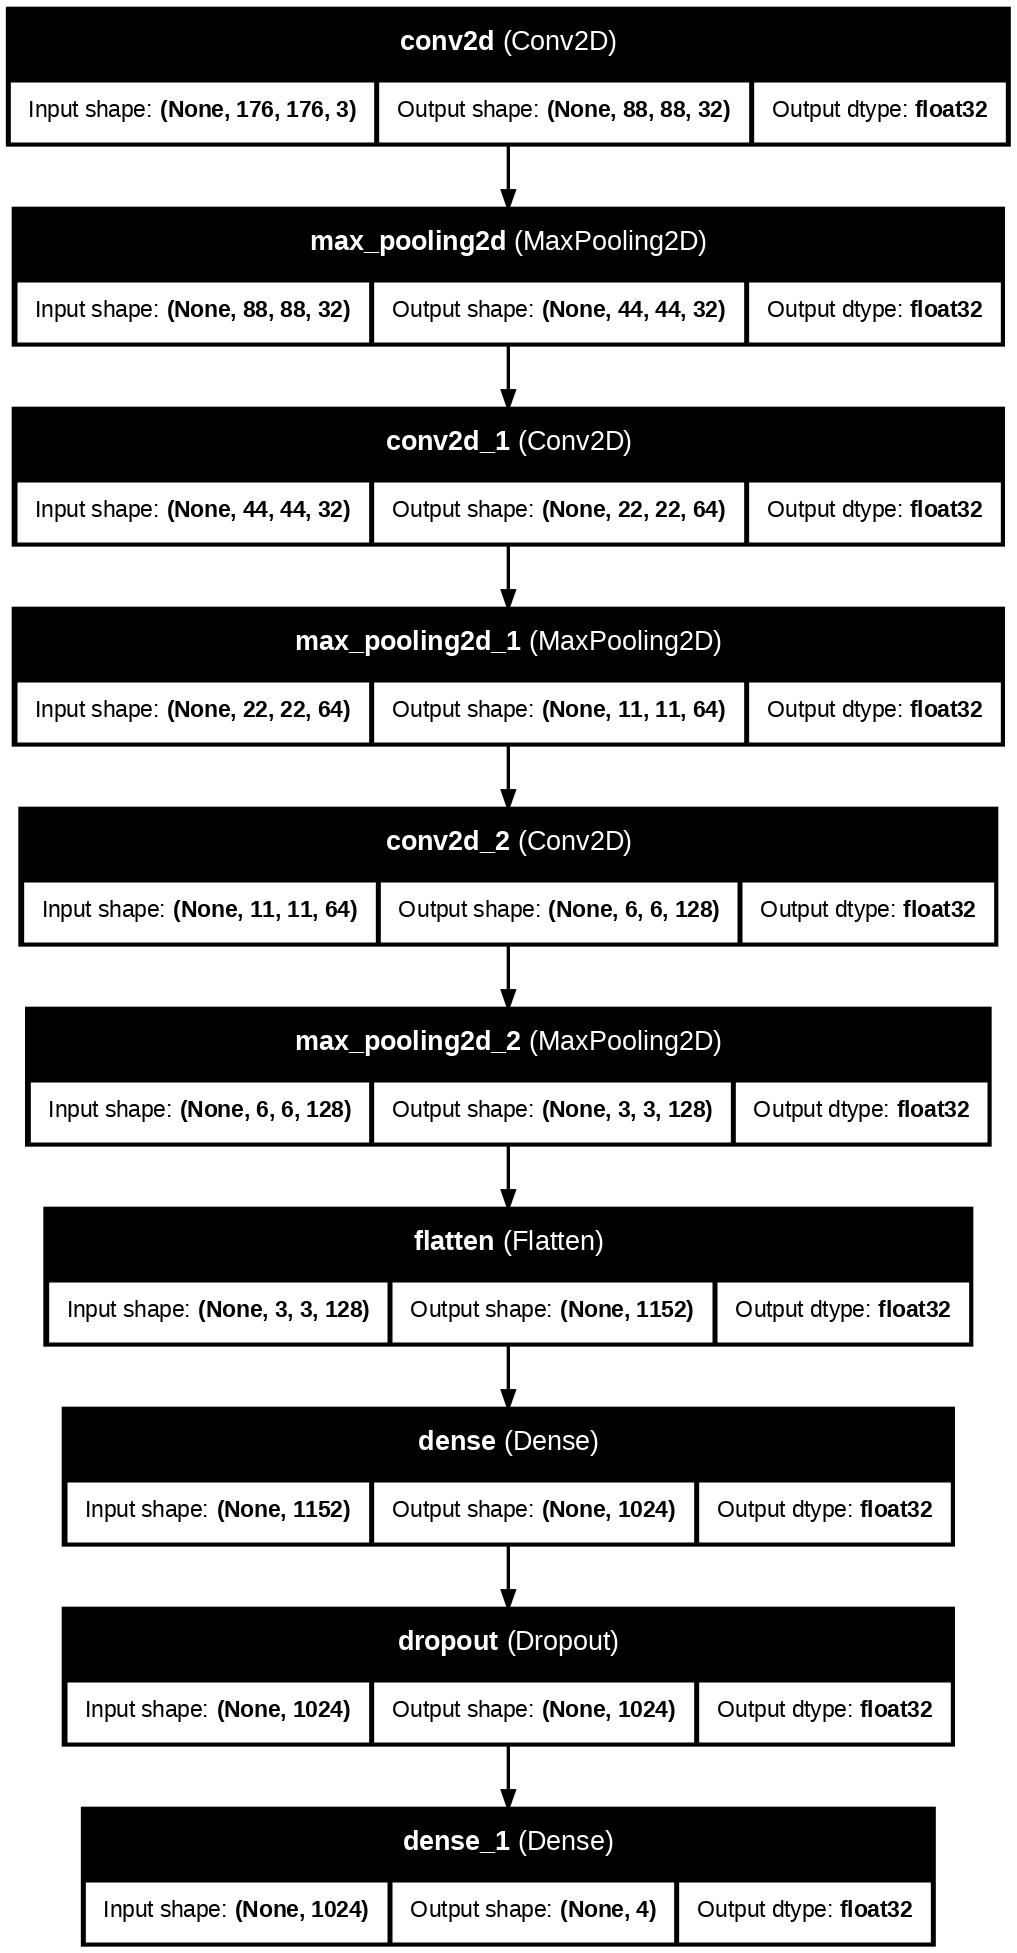

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Import necessary libraries
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the dataset
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Reshape the data for the model
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255
X_val = X_val.reshape((X_val.shape[0], 28, 28, 1)).astype('float32') / 255

# Convert labels to categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Define the model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Define callbacks
checkpoint_cb = ModelCheckpoint("model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8785 - loss: 0.4303 - val_accuracy: 0.9585 - val_loss: 0.1432
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9644 - loss: 0.1212 - val_accuracy: 0.9708 - val_loss: 0.0985
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9762 - loss: 0.0779 - val_accuracy: 0.9758 - val_loss: 0.0796
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9828 - loss: 0.0555 - val_accuracy: 0.9760 - val_loss: 0.0767
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9870 - loss: 0.0429 - val_accuracy: 0.9769 - val_loss: 0.0790
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9896 - loss: 0.0334 - val_accuracy: 0.9771 - val_loss: 0.0702
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9922 - loss: 0.0247 - val_accuracy: 0.9788 - val_loss: 0.0758
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9939 - loss

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.925717  0.260329        0.9585  0.143243
1   0.967033  0.111965        0.9708  0.098532
2   0.976633  0.077058        0.9758  0.079638
3   0.982183  0.056869        0.9760  0.076704
4   0.986017  0.045119        0.9769  0.079023
5   0.988850  0.034895        0.9771  0.070220
6   0.991133  0.027958        0.9788  0.075762
7   0.992883  0.022448        0.9737  0.092676
8   0.994133  0.019025        0.9766  0.083905
9   0.995167  0.015685        0.9785  0.075567
10  0.995800  0.013083        0.9752  0.091060
11  0.996767  0.010759        0.9795  0.081443
12  0.996800  0.009961        0.9796  0.087881
13  0.997000  0.009558        0.9793  0.091127
14  0.998083  0.006630        0.9790  0.093170
15  0.997317  0.008375        0.9775  0.094752

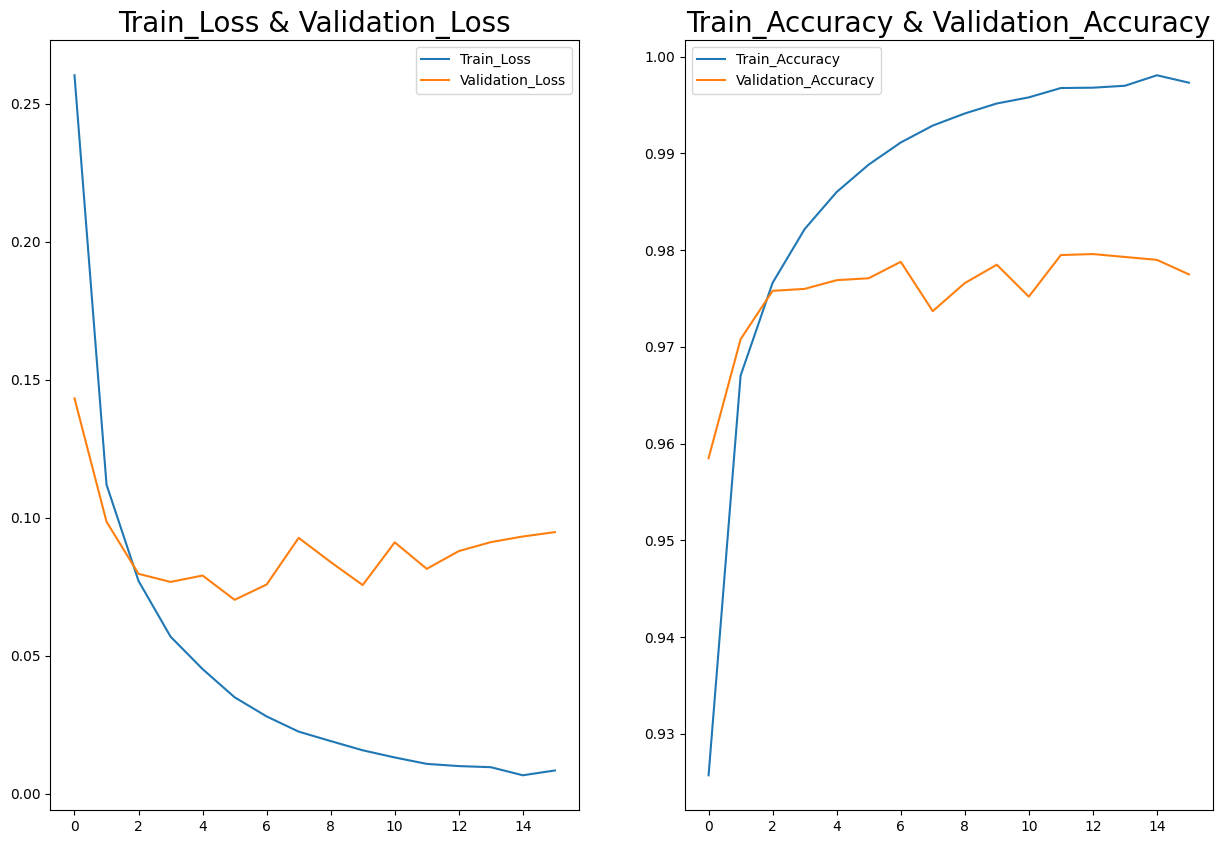

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the test data (similar to how training data was preprocessed)
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255
y_test = to_categorical(y_test)

# Evaluate the model on the test data
score, acc = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print('Test Loss =', score)
print('Test Accuracy =', acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0857
Test Loss = 0.07021985203027725
Test Accuracy = 0.9771000146865845


In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Actual  Prediction
0          7           7
1          2           2
2          1           1
3          0           0
4          4           4
...      ...         ...
9995       2           2
9996       3           3
9997       4           4
9998       5           5
9999       6           6

[10000 rows x 2 columns]

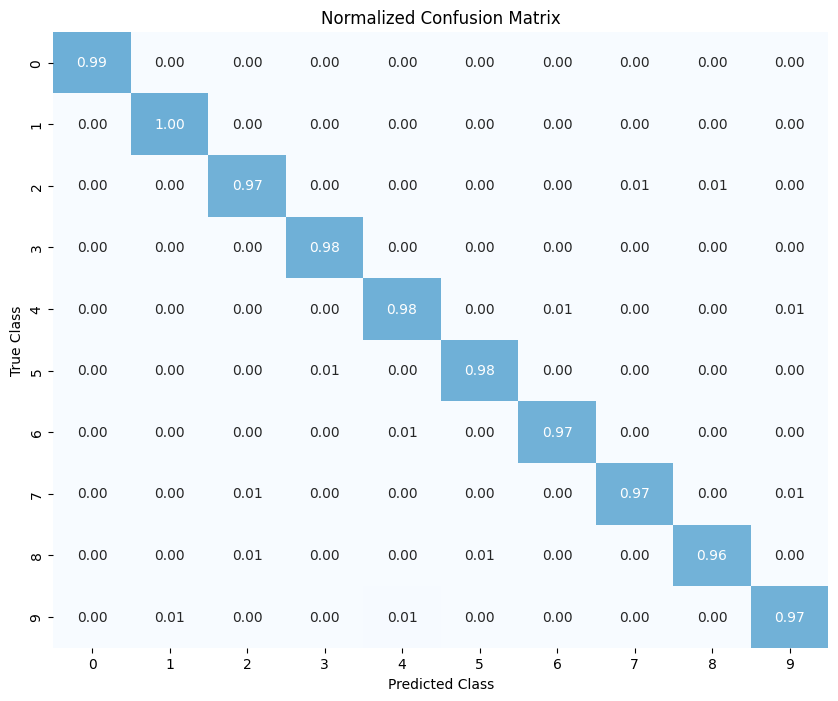

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check if y_test_ is one-hot encoded or already class indices
if len(y_test_.shape) == 2:  # One-hot encoded
    y_test_classes = np.argmax(y_test_, axis=1)  # Convert one-hot to class indices
else:  # Already class indices
    y_test_classes = y_test_

# Assuming you already have y_pred_classes from the model predictions
# y_pred_classes = np.argmax(y_pred, axis=1)  # Uncomment if you haven't done this

# Generate the confusion matrix
CM = confusion_matrix(y_test_classes, y_pred_classes)

# Normalize the confusion matrix
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(CM_percent, fmt='.2f', center=True, cbar=False, annot=True, cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Ensure y_pred contains predicted class labels
# If y_pred is continuous (e.g., probabilities), use argmax to convert it to class labels
if y_pred.ndim > 1:  # Assuming y_pred is a 2D array with probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Use argmax for multiclass
else:
    y_pred_classes = y_pred  # y_pred is already class labels

# Now, generate the classification report
ClassificationReport = classification_report(y_test_, y_pred_classes)
print('Classification Report is:\n', ClassificationReport)


Classification Report is:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.96      0.98      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000





## VGG19 MODEL


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 176, 176, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 176, 176, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 176, 176, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 88, 88, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 88, 88, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 44, 44, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        51,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,075,588 (76.58 MB)

 Trainable params: 51,204 (200.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

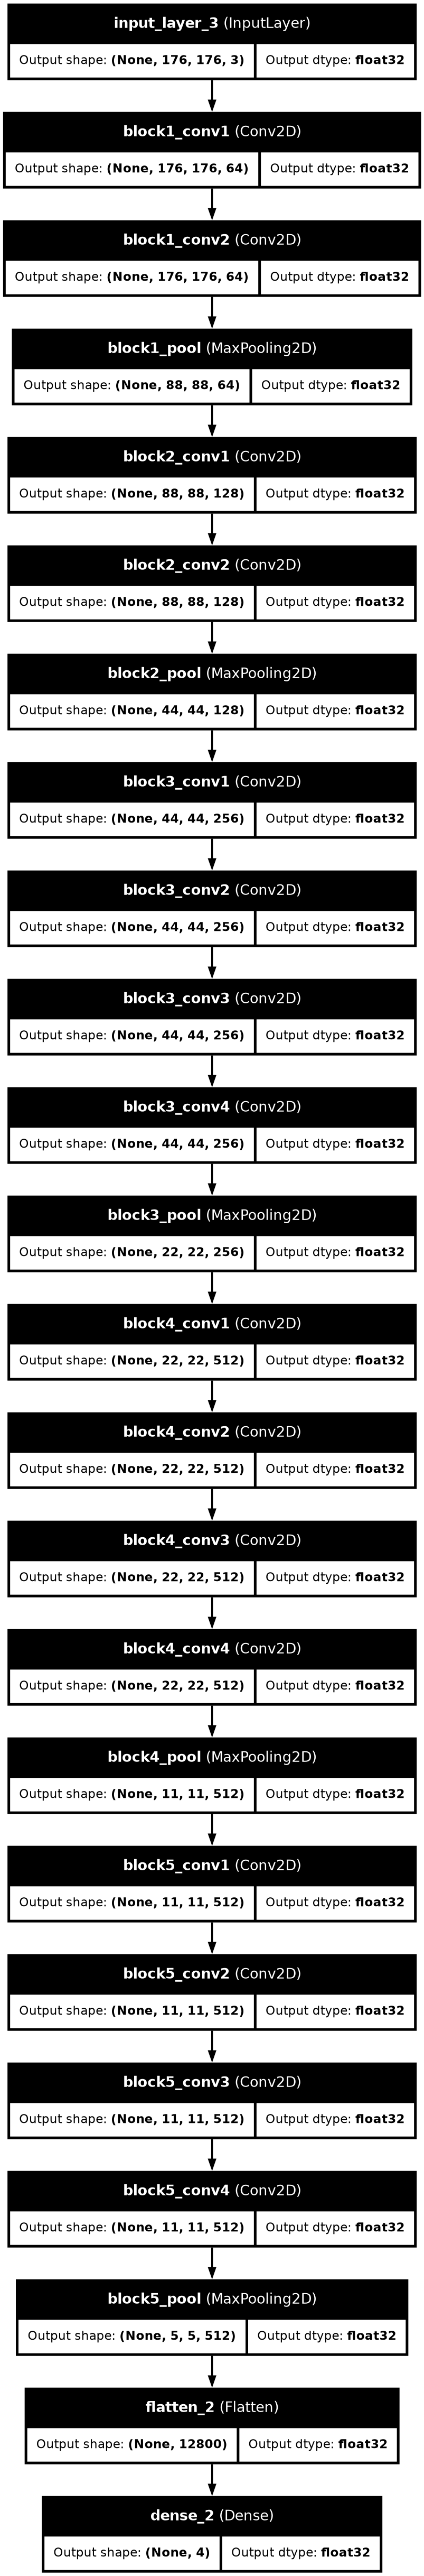

In [ ]:
tf.keras.utils.plot_model(modelvgg, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("modelvgg.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
modelvgg.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = modelvgg.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
  2/280 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.2422 - loss: 1.8803   

I0000 00:00:1713369180.047274      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713369180.071380      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5652 - loss: 1.0999

W0000 00:00:1713369208.804948      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 58s 125ms/step - accuracy: 0.5655 - loss: 1.0989 - val_accuracy: 0.7849 - val_loss: 0.5400
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.7779 - loss: 0.5447 - val_accuracy: 0.8547 - val_loss: 0.4366
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.8387 - loss: 0.4220 - val_accuracy: 0.8521 - val_loss: 0.3828
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - accuracy: 0.8896 - loss: 0.3270 - val_accuracy: 0.8797 - val_loss: 0.3528
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.8929 - loss: 0.3057 - val_accuracy: 0.8938 - val_loss: 0.3118
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.9041 - loss: 0.2767 - val_accuracy: 0.8833 - val_loss: 0.3099
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.9201 - loss: 0.2449 - val_accuracy: 0.9057 - val_loss: 0.2685
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.9374 - loss: 0.211

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.665513  0.814889      0.784896  0.540021
1   0.789732  0.510386      0.854688  0.436563
2   0.838616  0.411949      0.852083  0.382822
3   0.879241  0.340220      0.879687  0.352792
4   0.896987  0.297711      0.893750  0.311763
..       ...       ...           ...       ...
91  1.000000  0.003547      0.977604  0.069319
92  1.000000  0.004425      0.978646  0.066753
93  1.000000  0.003500      0.976042  0.075465
94  1.000000  0.003607      0.977604  0.067996
95  0.999665  0.005433      0.966667  0.092415

[96 rows x 4 columns]

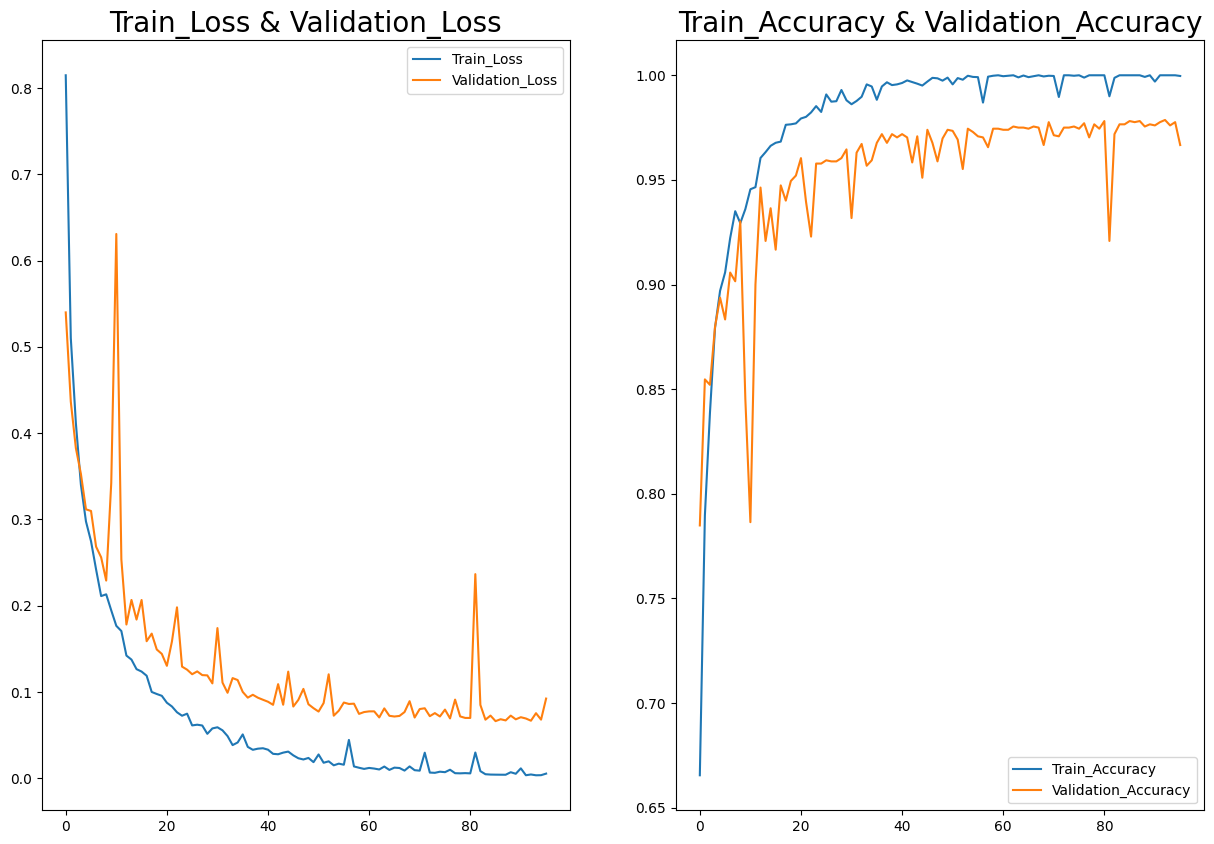

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= modelvgg.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9786 - loss: 0.0733
Test Loss = 0.06523068249225616
Test Accuracy = 0.9802083373069763


In [ ]:
predictions = modelvgg.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

 2/60 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step 

W0000 00:00:1713373005.763726      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           0
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           0
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

array([[478,   0,   0,   2],
       [  0, 480,   0,   0],
       [  3,   0, 463,  14],
       [  1,   3,  15, 461]])

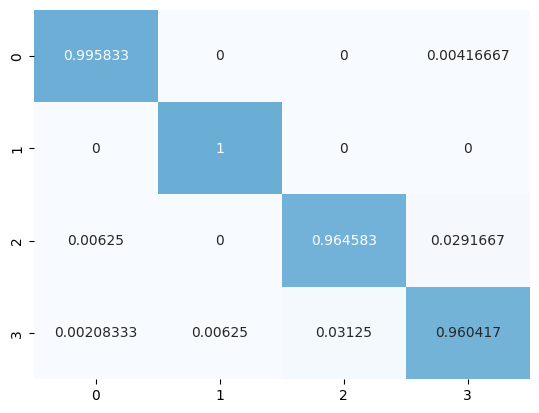

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      0.99       480
           1       0.99      1.00      1.00       480
           2       0.97      0.96      0.97       480
           3       0.97      0.96      0.96       480

    accuracy                           0.98      1920
   macro avg       0.98      0.98      0.98      1920
weighted avg       0.98      0.98      0.98      1920



## ResNet18

In [ ]:
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D,Add,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [ ]:
from keras.models import Model

class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):

        super().__init__()
        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]
        KERNEL_SIZE = (3, 3)

        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:

            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        return out


In [ ]:
base_modelresnet = ResNet18(10)
base_modelresnet.build(input_shape = (None,176,176,3))
model=Sequential()
model.add(base_modelresnet)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
checkpoint_cb = ModelCheckpoint("resnet.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=METRICS)
hist = model.fit(X_train,y_train, epochs=20, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'res_net18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/20
  1/280 ━━━━━━━━━━━━━━━━━━━━ 3:12:22 41s/step - acc: 0.2188 - auc: 0.5181 - loss: 1.5033

I0000 00:00:1713703131.935469      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/280 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - acc: 0.2638 - auc: 0.5175 - loss: 1.5013 - val_acc: 0.3656 - val_auc: 0.6018 - val_loss: 1.3460
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - acc: 0.3716 - auc: 0.6619 - loss: 1.2782 - val_acc: 0.4208 - val_auc: 0.7106 - val_loss: 1.2036
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - acc: 0.4460 - auc: 0.7330 - loss: 1.1787 - val_acc: 0.4677 - val_auc: 0.7424 - val_loss: 1.1829
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - acc: 0.5256 - auc: 0.8028 - loss: 1.0311 - val_acc: 0.4839 - val_auc: 0.7834 - val_loss: 1.1308
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - acc: 0.5730 - auc: 0.8489 - loss: 0.9081 - val_acc: 0.2505 - val_auc: 0.5134 - val_loss: 6.6146
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - acc: 0.6084 - auc: 0.8681 - loss: 0.8452 - val_acc: 0.5500 - val_auc: 0.8456 - val_loss: 0.9181
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - acc: 0.6495 - auc: 0.8884 - loss: 0.7860 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net18 (ResNet18)            │ (32, 512)              │    11,190,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (32, 512)              │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (32, 32)               │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 32)               │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (32, 32)               │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 33,692,942 (128.53 MB)

 Trainable params: 11,227,268 (42.83 MB)

 Non-trainable params: 11,136 (43.50 KB)

 Optimizer params: 22,454,538 (85.66 MB)

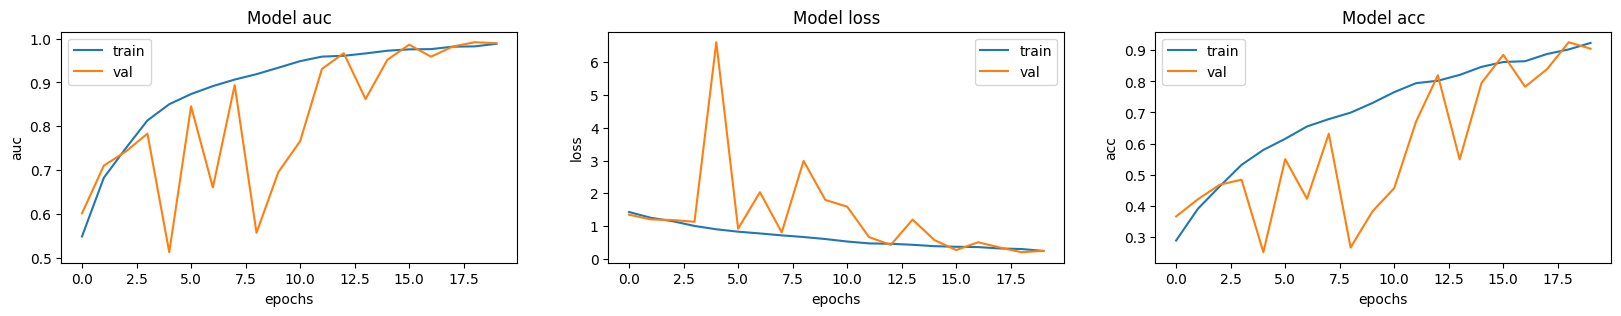

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
score = model.evaluate(X_test,y_test)
print('Test Loss =', score[0])
print('Test Accuracy =', score[1])
print('Test AUC =', score[2])

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9076 - auc: 0.9867 - loss: 0.2557
Test Loss = 0.21729208528995514
Test Accuracy = 0.921875
Test AUC = 0.990468442440033


In [ ]:
def roundoff(arr):
    threshold = 0.5 # Threshold for rounding off probabilities
    rounded_arr = (arr > threshold).astype(int) # Convert probabilities to binary values
    return rounded_arr

In [ ]:
from sklearn.metrics import classification_report

# Predict the labels for the testing set
y_preds = model.predict(X_test)

# Round off the predictions
y_preds_rounded = roundoff(y_preds)

# Print the classification report
print(classification_report(y_test, y_preds_rounded, target_names=classes))

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.99      0.98       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.82      0.92      0.87       480
VeryMildDemented       0.91      0.77      0.84       480

       micro avg       0.92      0.92      0.92      1920
       macro avg       0.92      0.92      0.92      1920
    weighted avg       0.92      0.92      0.92      1920
     samples avg       0.92      0.92      0.92      1920



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


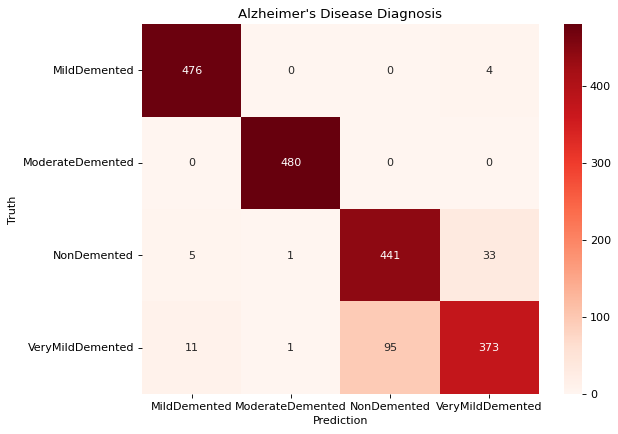

In [ ]:
pred_ls = np.argmax(y_preds, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Reds', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### DenseNet121 Model

In [ ]:
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

#import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
#import tensorflow_addons as tfa
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


In [ ]:
# Define custom callback to stop training when accuracy exceeds 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

# Instantiate callbacks
my_callback = MyCallback()

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications import DenseNet121

# Load pre-trained DenseNet121 model
# input_shape = (224, 224, 3)
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
# Load DenseNet121 base model
base_model = DenseNet121(input_shape=(176, 176, 3), include_top=False, weights="imagenet")
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define custom head for classification
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(4, activation='softmax')(x)  # Assuming 4 classes for classification

# Create custom model
custom_densenet_model = Model(inputs=base_model.input, outputs=output, name="densenet_cnn_model")

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.F1Score(name='f1_score')]

CALLBACKS = [my_callback, rop_callback]

# Compile the model
custom_densenet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

# Print model summary
custom_densenet_model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "densenet_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 182, 182,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 44, 44,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 44, 44,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 44, 44,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 44, 44,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 44, 44,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 44, 44,    │     12,288 │ conv2_block2_0_r

 Total params: 7,742,980 (29.54 MB)

 Trainable params: 701,508 (2.68 MB)

 Non-trainable params: 7,041,472 (26.86 MB)

In [ ]:
# Fit the model to the training data
EPOCHS = 100
history = custom_densenet_model.fit(X_train, y_train,validation_data=(X_val, y_val),callbacks=CALLBACKS,epochs=EPOCHS)

Epoch 1/100
  1/280 ━━━━━━━━━━━━━━━━━━━━ 3:05:52 40s/step - acc: 0.1875 - auc: 0.4600 - f1_score: 0.2093 - loss: 2.1948

I0000 00:00:1712334875.528136     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712334875.599986     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.4085 - auc: 0.6769 - f1_score: 0.4055 - loss: 1.4161

W0000 00:00:1712334902.410133     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - acc: 0.4088 - auc: 0.6773 - f1_score: 0.4058 - loss: 1.4152 - val_acc: 0.6953 - val_auc: 0.9197 - val_f1_score: 0.6882 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - acc: 0.6487 - auc: 0.8854 - f1_score: 0.6443 - loss: 0.7985 - val_acc: 0.7453 - val_auc: 0.9430 - val_f1_score: 0.7421 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - acc: 0.6984 - auc: 0.9131 - f1_score: 0.6964 - loss: 0.6959 - val_acc: 0.7755 - val_auc: 0.9545 - val_f1_score: 0.7686 - val_loss: 0.5032 - learning_rate: 0.0010
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - acc: 0.7272 - auc: 0.9318 - f1_score: 0.7245 - loss: 0.6180 - val_acc: 0.8104 - val_auc: 0.9674 - val_f1_score: 0.8079 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - acc: 0.7650 - auc: 0.9449 - f1_score: 0.7623 - loss: 0.5529 - val_acc: 0.8375 

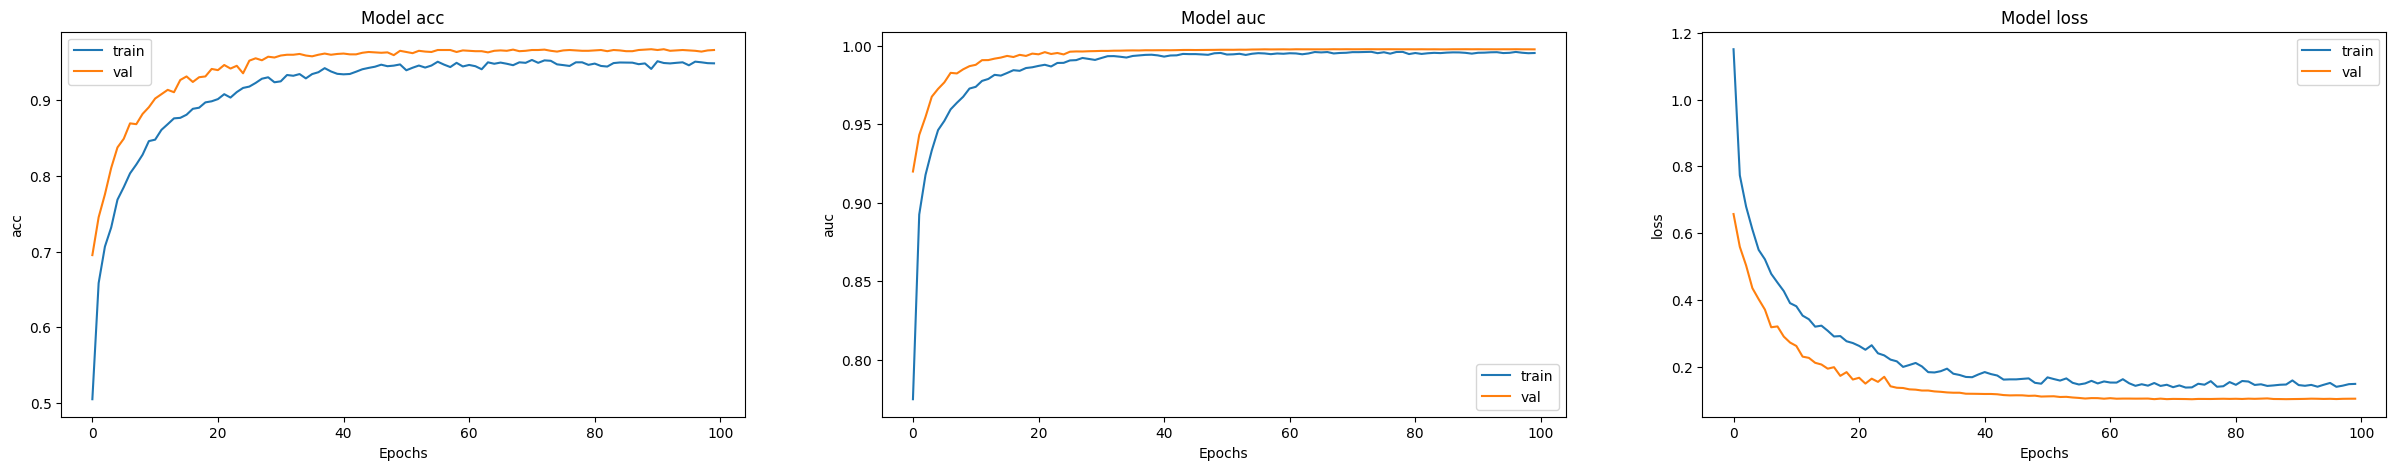

In [ ]:
# Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# Evaluating the model on the data
test_scores = custom_densenet_model.evaluate(X_test, y_test)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))
#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - acc: 0.9599 - auc: 0.9978 - f1_score: 0.9592 - loss: 0.1094
Testing Accuracy: 96.82%


In [ ]:
pred_labels = custom_densenet_model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


In [ ]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

# Classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_labels, axis=1)))



              precision    recall  f1-score   support

           0       0.99      0.99      0.99       480
           1       1.00      1.00      1.00       480
           2       0.96      0.93      0.94       480
           3       0.93      0.96      0.94       480

    accuracy                           0.97      1920
   macro avg       0.97      0.97      0.97      1920
weighted avg       0.97      0.97      0.97      1920



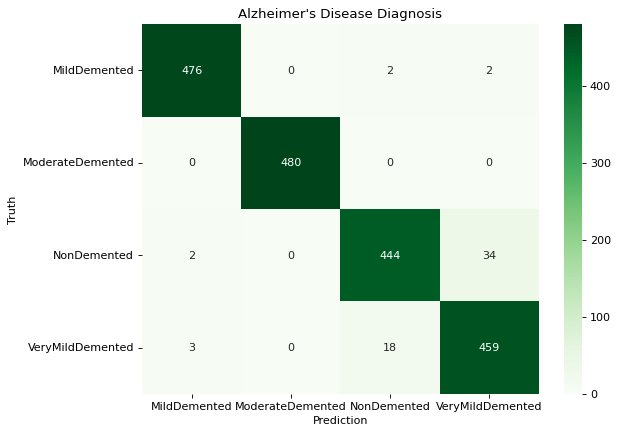

In [ ]:
# Plot the confusion matrix to understand the classification in detail
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=class_num,
                 yticklabels=class_num)

plt.title("Alzheimer's Disease Diagnosis")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show(ax)

In [ ]:
# Alternatively, you can save it with .keras extension
custom_densenet_model.save("alzheimer_densenet_cnn_model.keras")

## EfficientNetB2 & SMOTE

In [ ]:
!pip install imbalanced-learn # Install the imbalanced-learn library, which includes imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE # Now the import should work

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Atukuri Praneetha
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


100%|██████████| 34.1M/34.1M [00:00<00:00, 126MB/s]


In [ ]:
train_path = r"/content/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train"
test_path = r"/content/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test"
batch_s = 32
img_size= (224,224)
mode = "rgb"

In [ ]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [ ]:
train_df = df_maker(train_path)

In [ ]:
test_df = df_maker(test_path)

In [ ]:
all_data = pd.concat([train_df,test_df])

In [ ]:
train_df

file_paths            labels
0     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
1     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
2     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
3     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
4     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
...                                                 ...               ...
5116  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
5117  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
5118  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
5119  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
5120  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented

[5121 rows x 2 columns]

In [ ]:
test_df

file_paths            labels
0     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
1     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
2     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
3     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
4     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
...                                                 ...               ...
1274  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1275  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1276  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1277  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1278  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented

[1279 rows x 2 columns]

In [ ]:
all_data

file_paths            labels
0     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
1     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
2     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
3     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
4     /content/alzheimers-dataset-4-class-of-images/...       NonDemented
...                                                 ...               ...
1274  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1275  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1276  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1277  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented
1278  /content/alzheimers-dataset-4-class-of-images/...  ModerateDemented

[6400 rows x 2 columns]

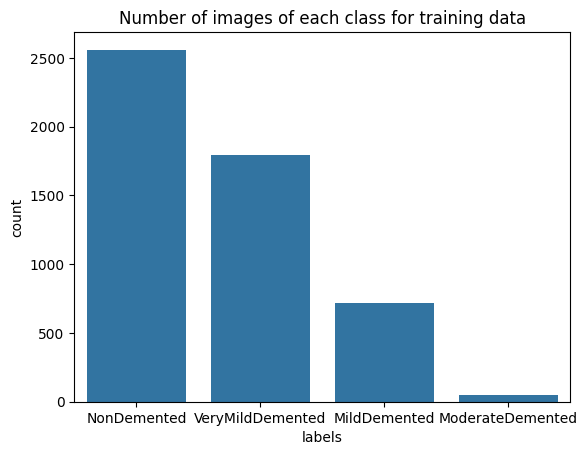

In [ ]:
train_count_df = train_df.labels.value_counts().reset_index()
sns.barplot(data=train_count_df,x="labels",y="count")
plt.title("Number of images of each class for training data")
plt.show()

In [ ]:
train_count_df

labels  count
0       NonDemented   2560
1  VeryMildDemented   1792
2      MildDemented    717
3  ModerateDemented     52

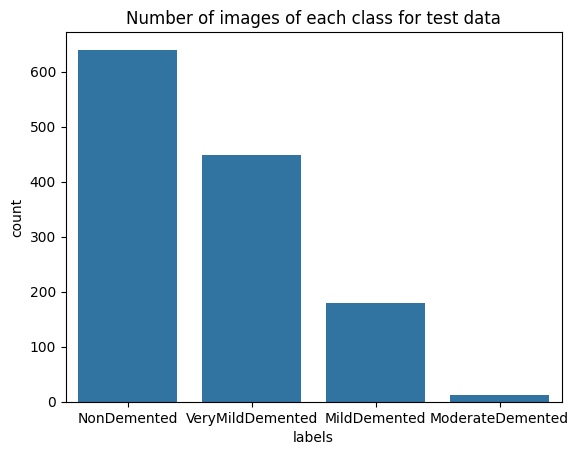

In [ ]:
test_count_df = test_df.labels.value_counts().reset_index()
sns.barplot(data=test_count_df,x="labels",y="count")
plt.title("Number of images of each class for test data")
plt.show()

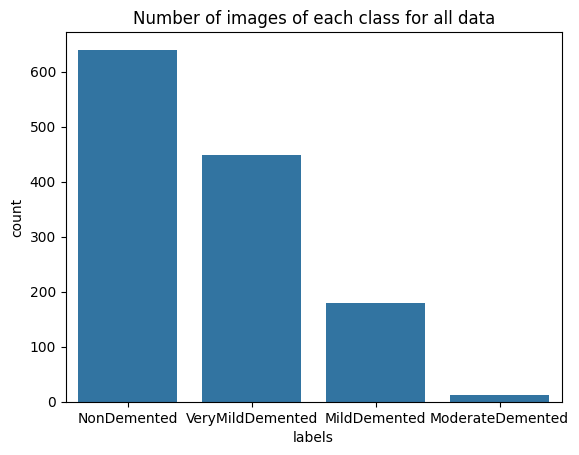

In [ ]:
data_count_df = all_data.labels.value_counts().reset_index()
sns.barplot(data=test_count_df,x="labels",y="count")
plt.title("Number of images of each class for all data")
plt.show()

In [ ]:
data_count_df

labels  count
0       NonDemented   3200
1  VeryMildDemented   2240
2      MildDemented    896
3  ModerateDemented     64

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
data_generator = datagen.flow_from_dataframe(
    all_data,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    batch_size=batch_s,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 6400 validated image filenames belonging to 4 classes.


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

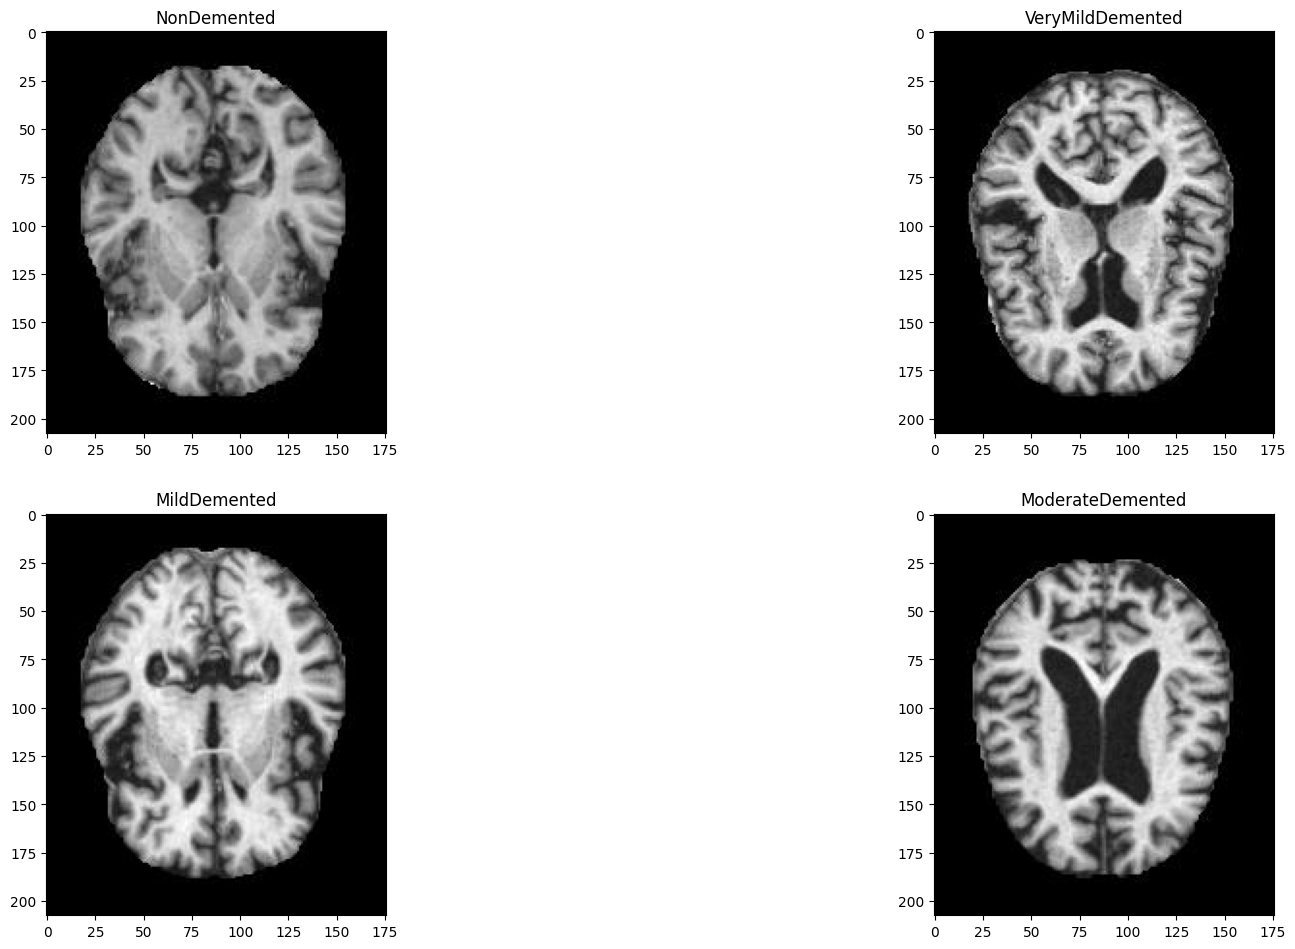

In [ ]:
class_dirs = os.listdir(train_path)
plt.figure(figsize=(21, 24))
for i in range(len(class_dirs)):
    plt.subplot(4,2,i+1)
    img_path = f"{train_path}/{class_dirs[i]}/{os.listdir(f'{train_path}/{class_dirs[i]}')[0]}"
    img = plt.imread(img_path)/255
    plt.title(class_dirs[i])
    plt.imshow(img,cmap="gray")

In [ ]:
data_imgs=np.concatenate([next(data_generator)[0] for i in range(data_generator.__len__())])
data_labels=np.concatenate([next(data_generator)[1] for i in range(data_generator.__len__())])

In [ ]:
data_imgs = data_imgs.reshape(-1, 224*224* 3)
data_imgs,data_labels = SMOTE(random_state=7).fit_resample(data_imgs,data_labels)
data_imgs = data_imgs.reshape(-1,224,224,3)

In [ ]:
data_generator.class_indices


{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
map  ={0:'MildDemented',
 1:'ModerateDemented',
 2:'NonDemented',
 3:'VeryMildDemented'}

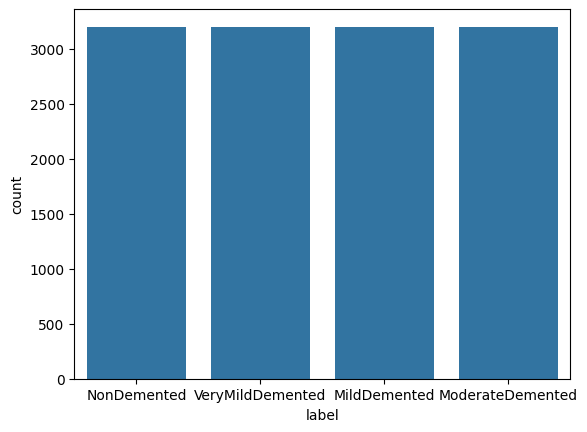

In [ ]:
labels=pd.Series([map[i] for i in np.argmax(data_labels,axis=1)],name="label")
labels_count = labels.value_counts().reset_index()
sns.barplot(data=labels_count,x="label",y="count")
plt.show()

In [ ]:
labels_count

label  count
0       NonDemented   3200
1  VeryMildDemented   3200
2      MildDemented   3200
3  ModerateDemented   3200

In [ ]:
train_imgs, test_imgs, train_labels,test_labels = train_test_split(data_imgs,data_labels,  train_size= 0.75, shuffle= True, random_state= 7,stratify=data_labels)

In [ ]:
test_imgs, val_imgs, test_labels,val_labels = train_test_split(test_imgs,test_labels,  train_size= 0.5, shuffle= True, random_state= 7,stratify= test_labels)

In [ ]:
train_imgs.shape

(9600, 224, 224, 3)

In [ ]:
val_imgs.shape

(1600, 224, 224, 3)

In [ ]:
test_imgs.shape

(1600, 224, 224, 3)

In [ ]:
base_model =tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet", input_shape=(224,224,3),pooling='max')

31790344/31790344 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, Dropout # Import Dense and Dropout layers
from tensorflow.keras import regularizers  # Import regularizers
import tensorflow as tf
from tensorflow import keras

x = base_model.output
x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
# layer.trainable= False


model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(learning_rate=0.001),
              metrics=["accuracy", "AUC"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  # Import ReduceLROnPlateau

checkpoint = ModelCheckpoint('alzheimer\'s_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
history = model.fit(
    train_imgs,train_labels,
    epochs = 10,
    validation_data = [val_imgs,val_labels],
    batch_size=batch_s,
    callbacks = [checkpoint,reduce_lr]
)

Epoch 1/10
300/300 [==============================] - 532s 2s/step - loss: 1.2882 - accuracy: 0.6589 - auc: 0.8906 - val_loss: 0.9716 - val_accuracy: 0.7325 - val_auc: 0.9373 - lr: 0.0010
Epoch 2/10
300/300 [==============================] - 487s 2s/step - loss: 0.7786 - accuracy: 0.8302 - auc: 0.9716 - val_loss: 0.6883 - val_accuracy: 0.8687 - val_auc: 0.9824 - lr: 0.0010
Epoch 3/10
300/300 [==============================] - 480s 2s/step - loss: 0.5977 - accuracy: 0.9104 - auc: 0.9896 - val_loss: 0.5750 - val_accuracy: 0.9125 - val_auc: 0.9912 - lr: 0.0010
Epoch 4/10
300/300 [==============================] - 468s 2s/step - loss: 0.4765 - accuracy: 0.9542 - auc: 0.9962 - val_loss: 0.5565 - val_accuracy: 0.9225 - val_auc: 0.9904 - lr: 0.0010
Epoch 5/10
300/300 [==============================] - 473s 2s/step - loss: 0.4321 - accuracy: 0.9646 - auc: 0.9968 - val_loss: 0.4365 - val_accuracy: 0.9656 - val_auc: 0.9957 - lr: 0.0010
Epoch 6/10
300/300 [==============================] - 468s 2

In [ ]:
model.evaluate(test_imgs,test_labels)

50/50 [==============================] - 15s 293ms/step - loss: 0.2138 - accuracy: 0.9919 - auc: 0.9999


[0.21376489102840424, 0.9918749928474426, 0.9999388456344604]

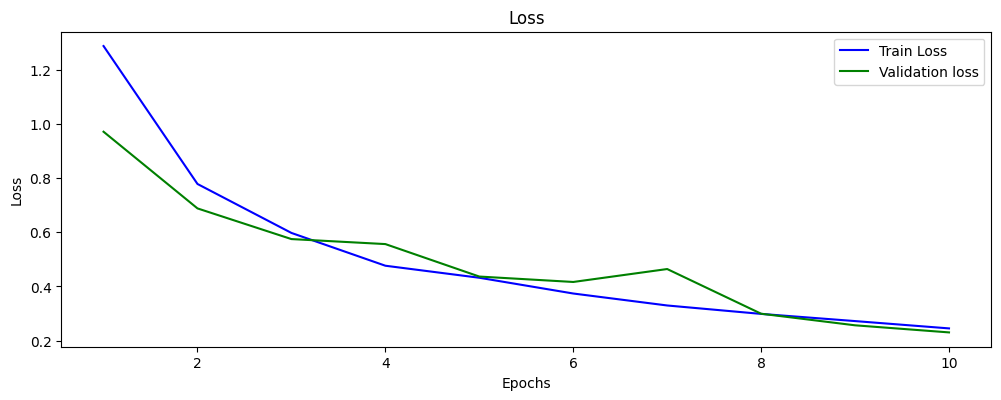

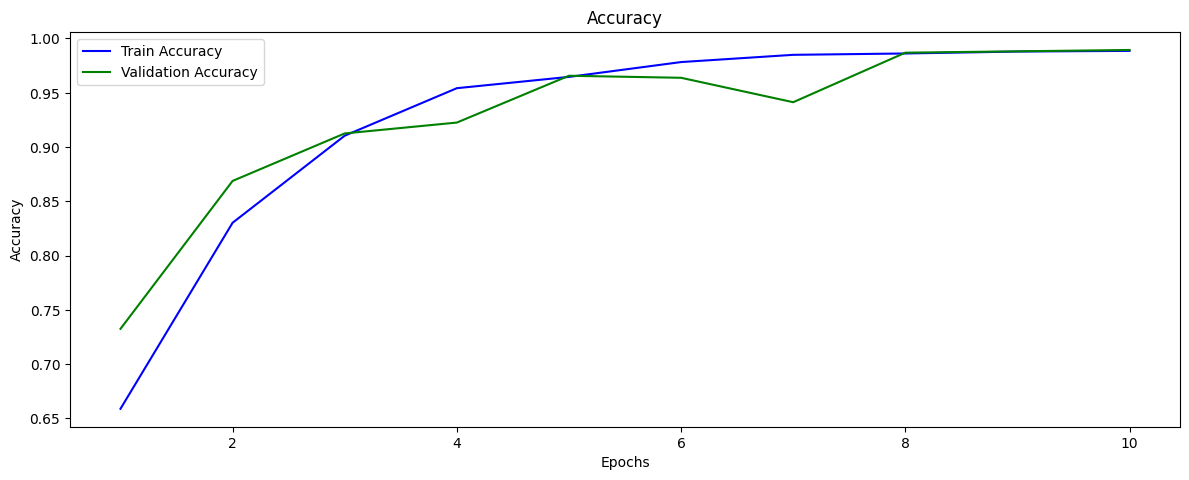

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_loss,'b',label="Train Loss")
plt.plot(epochs,val_loss,'g',label="Validation loss")
plt.title("Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_acc,'b',label="Train Accuracy")
plt.plot(epochs,val_acc,'g',label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_imgs)
y_pred = np.argmax(predictions, axis = 1)
y_true = np.argmax(test_labels, axis = 1)

50/50 [==============================] - 17s 296ms/step


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      0.97      0.98       400
           3       0.98      0.99      0.99       400

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



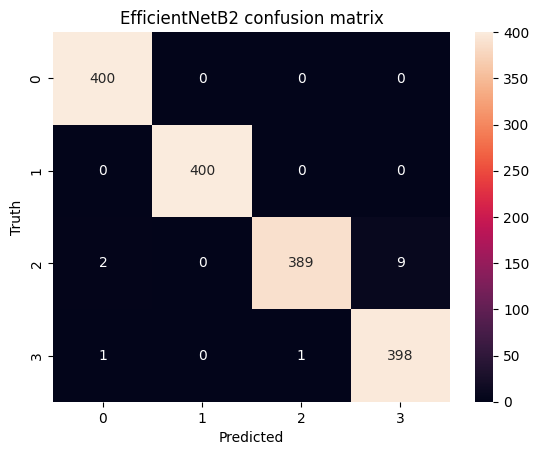

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("EfficientNetB2 confusion matrix")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/alzheimers_smote.h5')  # Save in HDF5 format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
